In [31]:
# 필요한 module import

# --- 데이터 처리 및 수학적 계산 관련 ---
import numpy as np              # 수치 연산을 위한 라이브러리 (벡터, 행렬 연산 등)
import pandas as pd             # 데이터프레임 형태의 데이터 처리 라이브러리
import matplotlib.pyplot as plt # 데이터 시각화를 위한 라이브러리
import datetime                 # 날짜 및 시간 관련 기능을 위한 모듈

# --- 통계 및 머신러닝 관련 ---
from scipy import stats         # 통계 분석용 라이브러리 (회귀, 분포, 검정 등)
from sklearn import linear_model # Scikit-learn의 선형 회귀 모델 등 머신러닝 도구
from sklearn.preprocessing import StandardScaler

# --- TensorFlow (딥러닝 프레임워크) ---
from tensorflow.keras.models import Sequential        # 순차적 모델 구조 정의
from tensorflow.keras.layers import Input, Flatten, Dense  # 입력, 전결합(Dense) 계층 등 구성
from tensorflow.keras.optimizers import Adam          # 최적화 알고리즘 (경사하강법 계열)
from tensorflow.keras.callbacks import TensorBoard    # 학습 과정 시각화를 위한 콜백 도구

# --- PyTorch (딥러닝 프레임워크) ---
import torch                     # PyTorch 기본 모듈
import torch.nn as nn             # 신경망 모델 구성용 모듈 (Layer, Loss 등 포함)
import torch.optim as optim       # 옵티마이저(경사하강법 등)를 제공하는 모듈


In [47]:
# Raw Data Loading & 데이터 전처리
df = pd.read_csv('./data/ozone.csv')
# df # 153 rows × 6 columns
training_data_set = df[['Solar.R', 'Wind','Temp', 'Ozone']]
# training_data_set # 153 rows × 2 columns

# 데이터 전처리
# 1. 결측치 처리 - 무조건 삭제
training_data_set = training_data_set.dropna(how='any')
print(training_data_set) # 116 rows × 2 columns

# 2. 이상치 처리 - Outliner 처리
# 종속변수인 Ozone에 이상치가 있으면 해당 행을 삭제
# zscore가 1.8 초과하거나 -1.8 미만인 데이터는 이상치로 간주
mask = np.abs(stats.zscore(training_data_set['Ozone'])) <= 1.8
training_data_set = training_data_set.loc[mask]
print(training_data_set) # 109 rows × 2 columns

# 학습데이터셋을 생성
x_data = training_data_set.drop('Ozone', axis=1, inplace=False).values
y_data = training_data_set['Ozone'].values.reshape(-1,1)

# 3. 정규화 (Normalization)
# 정규화 방식은 standardization(표준화)를 이용해서 처리
# 원래 값을 다른 값으로 변경해서 모델을 만들려고 해요
scaler_x = StandardScaler() # 독립변수용 scaler
scaler_y = StandardScaler() # 종속변수용 scaler

scaler_x.fit(x_data)
scaler_y.fit(y_data)
# scaler는 변환을 시켜주는 함수
# scaler는 평균, 표준편차를 알고 있어야 해요!
# 위의 코드는 scaler_x가 x_data에 대한 평균과 표준편차를 알아가는 코드

x_data_norm = scaler_x.transform(x_data)
y_data_norm = scaler_y.transform(y_data)

# 온도와 오존량을
# 표준변화량(z-score)를 이용해서 정규화 할 수 있어요!
# 학습데이터가 바뀌었어요

     Solar.R  Wind  Temp  Ozone
0      190.0   7.4    67   41.0
1      118.0   8.0    72   36.0
2      149.0  12.6    74   12.0
3      313.0  11.5    62   18.0
6      299.0   8.6    65   23.0
..       ...   ...   ...    ...
147     20.0  16.6    63   14.0
148    193.0   6.9    70   30.0
150    191.0  14.3    75   14.0
151    131.0   8.0    76   18.0
152    223.0  11.5    68   20.0

[111 rows x 4 columns]
     Solar.R  Wind  Temp  Ozone
0      190.0   7.4    67   41.0
1      118.0   8.0    72   36.0
2      149.0  12.6    74   12.0
3      313.0  11.5    62   18.0
6      299.0   8.6    65   23.0
..       ...   ...   ...    ...
147     20.0  16.6    63   14.0
148    193.0   6.9    70   30.0
150    191.0  14.3    75   14.0
151    131.0   8.0    76   18.0
152    223.0  11.5    68   20.0

[104 rows x 4 columns]


In [53]:
# sklearn 구현

# 모델 생성
sklearn_model = linear_model.LinearRegression()

# 모델 학습
sklearn_model.fit(x_data_norm,
                  y_data_norm)
# sklearn은 경사하강법으로 모델을 만들지 않아요!
# 최소제곱법이라는 수학공식을 이용해서 해(정답)을 찾는 방식을 이용
# 장점. 빠르게 모델을 만들 수 있어요
# 단점. 해당공식을 적용할 수 없는 것에 대해서는 학습하기 어려움

# 모델을 이용한 예측 => 독립변수(온도)의 값은 60도
# 이와 같은 경우에 데이터가 정규화 되어있으니
# 물어보는 값도 정규화해서 물어봐야 해요
test_data = scaler_x.transform(np.array([[150,10,80]]))
sklearn_result_norm = sklearn_model.predict(test_data)
sklearn_result = scaler_y.inverse_transform(sklearn_result_norm) # 0.30607583
print(sklearn_result_norm)

# 모델이 잘 만들어졌는지 그래프로 확인
# 독립변수 1개, 종속변수 1개로 scatter를 이용해 2차원으로 데이터를 표현
# scatter를 그리려면 x축에 1차원 데이터,
# y축에 1차원 데이터를 넣어야지 그려진다.
'''
plt.scatter(x_data_norm.ravel(),
            y_data_norm.ravel())
w = sklearn_model.coef_.ravel()
# 입력 변수 X가 1 단위 변할 때, 종속 변수 y가 얼마나 변하는지를 나타내는 값
b = sklearn_model.intercept_.ravel()
# 즉, 선이 y축을 어디에서 시작하느냐를 결정

# 모델을 직선으로 표현
plt.plot(x_data_norm.ravel(),
         x_data_norm.ravel() * w + b,
         color = 'r')
plt.show()
'''

[[0.15055727]]


"\nplt.scatter(x_data_norm.ravel(),\n            y_data_norm.ravel())\nw = sklearn_model.coef_.ravel()\n# 입력 변수 X가 1 단위 변할 때, 종속 변수 y가 얼마나 변하는지를 나타내는 값\nb = sklearn_model.intercept_.ravel()\n# 즉, 선이 y축을 어디에서 시작하느냐를 결정\n\n# 모델을 직선으로 표현\nplt.plot(x_data_norm.ravel(),\n         x_data_norm.ravel() * w + b,\n         color = 'r')\nplt.show()\n"

In [50]:
# Tensorflow 구현

# Model 구현
keras_model = Sequential()
# Layer 추가
keras_model.add(Input(shape=(3,)))
keras_model.add(Flatten()) # 우리 예제에서는 필요 없어요!
keras_model.add(Dense(units=1,
                      activation='linear',
                      name='output_layer'))

# Model 설정
keras_model.compile(optimizer=Adam(learning_rate=1e-3),
                    loss='mse')
# 부가기능 (callback) 생성
# 로그를 저장할 폴더를 지정
log_dir = './logs/' + datetime.datetime.now().strftime('%Y%M%D-%H%M%S')
tensorboard_callback = TensorBoard(log_dir=log_dir,
                                   histogram_freq=1)

# 모델 학습
keras_model.fit(x_data_norm,
                y_data_norm,
                epochs=1000,
                verbose=1,
                callbacks=[tensorboard_callback])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5878 
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5831  
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5794 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5755 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5719 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5681 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5645 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5612 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5576 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5544 
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5515 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5485 
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5453 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5420 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5390 
Ep

In [54]:
# 학습이 끝났으니,
# 온도가 60도 일때 오존량을 예측,
# 그래프로 모델이 잘 만들어졌는지 확인!
test_data = scaler_x.transform(np.array([[150,10,80]]))
keras_result_norm = keras_model.predict(test_data)
keras_result = scaler_y.inverse_transform(keras_result_norm)

print(keras_result)

# 그래프를 그릴려면 layer안에 있는 W와 b를 알아와야 해요!
keras_w, keras_b = keras_model.get_layer(name='output_layer').get_weights()

'''plt.scatter(x_data_norm.ravel(),
            y_data_norm.ravel())
plt.plot(x_data_norm.ravel(),
         x_data_norm.ravel() * keras_w.ravel() + keras_b.ravel(),
         color='r')

plt.show()'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[40.101135]]


"plt.scatter(x_data_norm.ravel(),\n            y_data_norm.ravel())\nplt.plot(x_data_norm.ravel(),\n         x_data_norm.ravel() * keras_w.ravel() + keras_b.ravel(),\n         color='r')\n\nplt.show()"

In [8]:
# PyTorch 구현

# TensorFlow는 ubuntu에 CUDA를 설치해서 GPU를 사용하는 방식
# 그래서 Ubuntu에 CUDA를 설치해서 GPU를 사용할 수 있도록 하고
# tensorflow도 pip로 설치해서 GPU용 tensorflow를 설치해야해요!
# 그리고 tensorflow는 2.10버전 이상부터는 Windows에 설정된
# GPU를 공식적으로 지원하지 않아요 => Linux, WSL
# Linux, WSL을 이용해서 CUDA를 설치한 후 사용해야 해요!

# PyTorch는 가상환경에 CUDA 라이브러리가 설치되요!
# WSL환경에서 Anaconda 환경에서 사용하는게 일반적  - VScode를 이용해서
# 사용하는 방식이 일반적인 방식!

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 만약 현재 가상환경에서 GPU를 사용할 수 있으면 'cuda'를 사용
# 그렇지 않으면 'cpu'값을 사용

# PyTorch에서도 TensorBoard를 이용해서 로그를 확인할 수 있어요

# 데이터 변환
x_tensor = torch.FloatTensor(x_data).to(device)
y_tensor = torch.FloatTensor(y_data).to(device)

# 모델 정의 (class로 정의)
class LinearRegressionModel(nn.Module):
    def __init__(self):
        # 모델의 구성요소를 여기에 정의
        # 모델의 기둥(레이어)를 여기에 property로 정의
        super().__init__()
        self.linear = nn.Linear(1,1)
        # 앞의 1은 입력의 개수(독립변수 개수),
        # 뒤에 1은 출력의 개수(units의 수)

    # 모델의 순전파를 진행하는 함수
    def forward(self, x):
        # 구성된 우리 모델에 데이터 x를 입력해서
        # 모델의 예측값을 리턴하는 함수
        return self.linear(x)
    
# 우리 model의 class의 instance를 생성!
torch_model = LinearRegressionModel().to(device)

# Loss 함수
criterion = nn.MSELoss() # MSE를 사용하는 loss함수 객체

# Optimizer 생성
optimizer = optim.Adam(torch_model.parameters(),
                       lr=1e-3)

# 반복학습 진행
epochs = 2000

for epoch in range(epochs):
    # 순전파 과정을 거쳐 우리 모델의 예측값을 얻어와요!
    y_pred = torch_model(x_tensor) # y_pred : 예측값.

    # 예측값과 정답을 비교해서 loss를 계산
    loss = criterion(y_pred, y_tensor)

    # loss값을 계산했으니 이제 optimizer로 가중치 계산
    # 역전파를 이용해서 기울기를 전파한 후 optimizer로 갱신
    optimizer.zero_grad() # 초기화
    loss.backward() # 역전파
    optimizer.step() # optimizer로 갱신

In [ ]:
# 학습이 끝났으니 예측작업과 그래프를 그려보면 될거 같아요!
with torch.no_grad():
    test_data = torch.tensor([[60]],
                               dtype= torch.float32).to(device)
    torch_result = torch_model(test_data)
    print(torch_result) # 29.7000

# sklearn : 0.3
# Tensorflow : 29.6
# PyTorch : 29.7

# 이유
# Tensorflow와 PyTorch 모델에는 문제가 없어요
# 데이터가 문제!
# Scikit-Learn은 수학적으로 정확한 해를 구하기 때문에 전처리 없이도 정답이 나오지만,
# TensorFlow / PyTorch는 경사하강법 기반이라 데이터 스케일링과 초기값에 따라 근사 오차가 생긴다.
# 데이터 전처리가 아직 끝나지 않았어요

# 그럼 어떤 데이터 처리가 필요한가요?
# 정규화(Normalization) => 필수
# 데이터의 scale을 조절해서 학습의 효율과 성능을 높이는 작업
# 만약 정규화를 하지 않으면 모델이 왜곡되서 잘못된 판단을 하게 되요!

# 1. 가장 큰 이유는 Feature간의 scale의 차를 없애는거예요!
# 2. 경사하강법을 사용할 때 속도 차이와 정확도 차이가 나요
# 스케일이 다르면 경사하강법을 사용할 때 문제가 발생
# 값도 부정확해지고 속도도 느려져요!

# 결국 정규화를 하지 않아서 발생하는 문제
# 3. 정규화(Normalization)
# 정규화 방식은


tensor([[29.7000]])


In [ ]:
# Multiple Linear Regression

# 오존데이터를 이용해서
# 다중선형회귀모델을 구현한 후
# 다음 데이터에 대한 오존값을 예측해 보세요!

# 태양광 -> 150
# 바람 -> 10
# 온도 -> 80
# 이럴 때 예측되는 오론량은 얼마인가요?

# Tensorflow와 PyTorch로 구현해서 예측값을 도출해보세요!


[예측 결과]
  Temp = 80
  Wind = 10
  Solar.R = 150
  → 예측된 Ozone 값: 40.9007

[회귀 계수 (weights)]
  Temp : 0.6198
  Wind : -0.2307
  Solar.R : 0.1506
절편(intercept): 0.0000

(시각화는 2개 이하의 독립변수에서만 지원됩니다.)


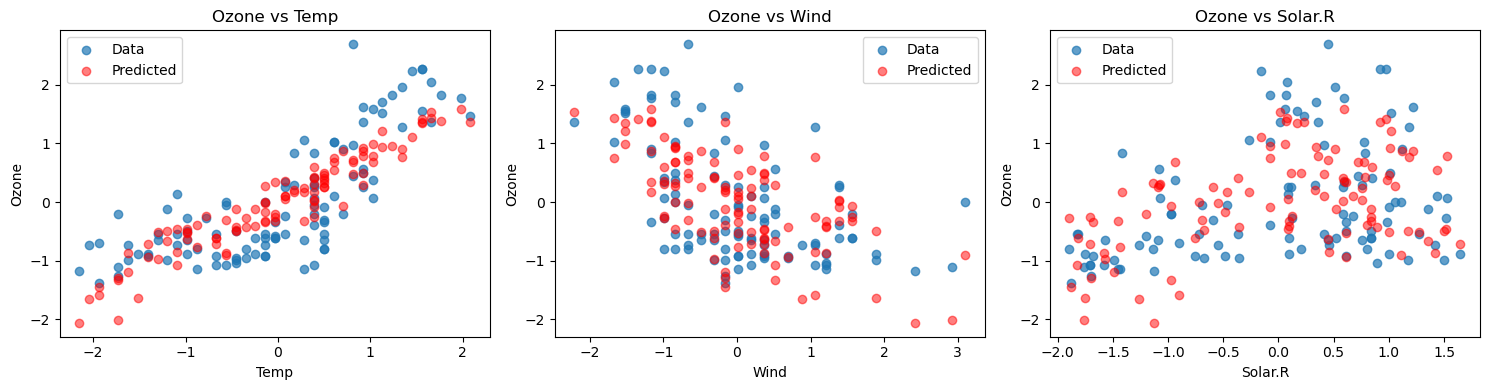

In [40]:
# ==========================================================
# [📦 Multiple Linear Regression 기본 템플릿]
#   작성자: ChatGPT
#   사용방법: 아래 변수만 수정하면 바로 실행 가능
# ==========================================================

# --- 1. 필요한 라이브러리 Import ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # 3D 시각화를 위한 라이브러리

# ==========================================================
# --- 2. 사용자 입력 구간 (★ 이 부분만 수정하면 됨) ---
# ==========================================================
DATA_PATH = './data/ozone.csv'   # CSV 파일 경로
X_COLUMNS = ['Temp', 'Wind', 'Solar.R']  # 독립변수 리스트
Y_COLUMN = 'Ozone'                       # 종속변수명
TEST_VALUE = [80, 10, 150]               # 예측할 독립변수 값들 (리스트 형태)
Z_THRESHOLD = 2.0                        # 이상치 기준 (Z-score 절대값)
NORMALIZE = True                         # 표준화(정규화) 여부 선택 (True/False)

# ==========================================================
# --- 3. 데이터 로딩 및 전처리 ---
# ==========================================================
df = pd.read_csv(DATA_PATH)
data = df[X_COLUMNS + [Y_COLUMN]].dropna()   # 결측치 제거

# 이상치 제거 (종속변수 기준)
mask = np.abs(stats.zscore(data[Y_COLUMN])) <= Z_THRESHOLD
data = data.loc[mask]

# 데이터셋 분리
x_data = data[X_COLUMNS].values
y_data = data[Y_COLUMN].values.reshape(-1, 1)

# 표준화 (Standardization)
if NORMALIZE:
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_x.fit(x_data)
    scaler_y.fit(y_data)

    x_data = scaler_x.transform(x_data)
    y_data = scaler_y.transform(y_data)

# ==========================================================
# --- 4. 모델 생성 및 학습 ---
# ==========================================================
model = linear_model.LinearRegression()
model.fit(x_data, y_data)

# ==========================================================
# --- 5. 예측 ---
# ==========================================================
# 예측용 입력 데이터 변환
test_data = np.array([TEST_VALUE])
if NORMALIZE:
    test_data = scaler_x.transform(test_data)

# 예측 (정규화된 모델 기준)
y_pred_norm = model.predict(test_data)

# 정규화 해제 (역변환)
if NORMALIZE:
    y_pred = scaler_y.inverse_transform(y_pred_norm)
else:
    y_pred = y_pred_norm

print(f"\n[예측 결과]")
for i, col in enumerate(X_COLUMNS):
    print(f"  {col} = {TEST_VALUE[i]}")
print(f"  → 예측된 {Y_COLUMN} 값: {y_pred[0][0]:.4f}")

# ==========================================================
# --- 6. 회귀 계수 확인 ---
# ==========================================================
print("\n[회귀 계수 (weights)]")
for col, coef in zip(X_COLUMNS, model.coef_.ravel()):
    print(f"  {col} : {coef:.4f}")
print(f"절편(intercept): {model.intercept_[0]:.4f}")

# ==========================================================
# --- 7. 시각화 (2개 변수까지만 시각화) ---
# ==========================================================
if len(X_COLUMNS) == 2:
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_data[:,0], x_data[:,1], y_data, label='Data Points', color='blue')
    
    # 예측면 (평면)
    x_surf, y_surf = np.meshgrid(np.linspace(x_data[:,0].min(), x_data[:,0].max(), 20),
                                 np.linspace(x_data[:,1].min(), x_data[:,1].max(), 20))
    z_surf = model.intercept_[0] + model.coef_[0,0]*x_surf + model.coef_[0,1]*y_surf
    ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.5, color='red')

    ax.set_xlabel(X_COLUMNS[0])
    ax.set_ylabel(X_COLUMNS[1])
    ax.set_zlabel(Y_COLUMN)
    plt.title(f"Multiple Linear Regression: {Y_COLUMN} vs {', '.join(X_COLUMNS)}")
    plt.show()
elif len(X_COLUMNS) == 1:
    # 단일 변수의 경우 2D 그래프로 표현
    plt.scatter(x_data, y_data, label='Data Points')
    plt.plot(x_data, model.predict(x_data), color='r', label='Regression Line')
    plt.xlabel(X_COLUMNS[0])
    plt.ylabel(Y_COLUMN)
    plt.legend()
    plt.show()
else:
    print("\n(시각화는 2개 이하의 독립변수에서만 지원됩니다.)")
# ==========================================================
# --- 8. 각 독립변수별 산점도 + 회귀선 시각화 ---
# ==========================================================
y_pred_all = model.predict(x_data)

plt.figure(figsize=(15, 4))
for i, col in enumerate(X_COLUMNS):
    plt.subplot(1, len(X_COLUMNS), i+1)
    plt.scatter(x_data[:, i], y_data, label='Data', alpha=0.7)
    plt.scatter(x_data[:, i], y_pred_all, color='red', label='Predicted', alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(Y_COLUMN)
    plt.title(f'{Y_COLUMN} vs {col}')
    plt.legend()
plt.tight_layout()
plt.show()




===== [TensorFlow Keras 모델 학습 시작] =====
Keras Weights: [ 0.6421991  -0.21770552  0.11203618]
Keras Bias: [-0.00555651]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Keras MSE: 0.269196

===== [PyTorch 모델 학습 시작] =====
[Epoch 50] Loss: 0.858555
[Epoch 100] Loss: 0.503557
[Epoch 150] Loss: 0.418893
[Epoch 200] Loss: 0.385463
[Epoch 250] Loss: 0.374039
[Epoch 300] Loss: 0.370888
PyTorch MSE: 0.262092
PyTorch Weights: [[ 0.6234213  -0.23597148  0.1286548 ]]
PyTorch Bias: [0.00131636]


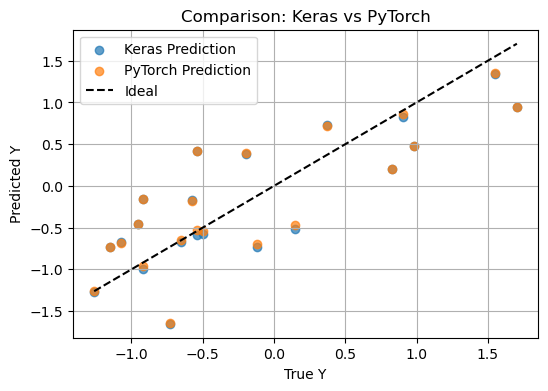

In [39]:
# ==========================================================
# [딥러닝 기반 Linear Regression 기본 템플릿]
#   TensorFlow + PyTorch 버전
# ==========================================================

# --- 공통 라이브러리 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# ==========================================================
# --- 1. 사용자 입력 영역 (★ 수정 포인트) ---
# ==========================================================
DATA_PATH = './data/ozone.csv'   # CSV 파일 경로
X_COLUMNS = ['Temp', 'Wind', 'Solar.R']  # 독립변수 리스트
Y_COLUMN = 'Ozone'                       # 종속변수
Z_THRESHOLD = 2.0                        # 이상치 기준
EPOCHS = 300                             # 학습 반복 횟수
LEARNING_RATE = 0.01                     # 학습률
NORMALIZE = True                         # 정규화 여부

# ==========================================================
# --- 2. 데이터 로딩 및 전처리 ---
# ==========================================================
df = pd.read_csv(DATA_PATH)
data = df[X_COLUMNS + [Y_COLUMN]].dropna()

# 이상치 제거 (Z-score)
mask = np.abs(stats.zscore(data[Y_COLUMN])) <= Z_THRESHOLD
data = data.loc[mask]

x_data = data[X_COLUMNS].values
y_data = data[Y_COLUMN].values.reshape(-1, 1)

# 표준화
if NORMALIZE:
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_x.fit(x_data)
    scaler_y.fit(y_data)
    x_data = scaler_x.transform(x_data)
    y_data = scaler_y.transform(y_data)

# Train/Test 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# ==========================================================
# --- 3. TensorFlow (Keras) 버전 ---
# ==========================================================
print("\n===== [TensorFlow Keras 모델 학습 시작] =====")

keras_model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(1)  # 선형회귀이므로 activation 없음
])

keras_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')
history = keras_model.fit(x_train, y_train, epochs=EPOCHS, verbose=0)

# 가중치 확인
keras_w, keras_b = keras_model.get_layer(index=0).get_weights()
print(f"Keras Weights: {keras_w.ravel()}")
print(f"Keras Bias: {keras_b}")

# 예측
keras_pred = keras_model.predict(x_test)
keras_mse = np.mean((keras_pred - y_test)**2)
print(f"Keras MSE: {keras_mse:.6f}")

# ==========================================================
# --- 4. PyTorch 버전 ---
# ==========================================================
print("\n===== [PyTorch 모델 학습 시작] =====")

# Tensor 변환
x_train_t = torch.tensor(x_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
x_test_t = torch.tensor(x_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# 모델 정의
class LinearRegressionModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
    def forward(self, x):
        return self.linear(x)

torch_model = LinearRegressionModel(x_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)

# 학습
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    y_pred = torch_model(x_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f"[Epoch {epoch+1}] Loss: {loss.item():.6f}")

# 예측
torch_model.eval()
with torch.no_grad():
    y_pred_torch = torch_model(x_test_t)
    torch_mse = criterion(y_pred_torch, y_test_t).item()

print(f"PyTorch MSE: {torch_mse:.6f}")
print("PyTorch Weights:", torch_model.linear.weight.data.numpy())
print("PyTorch Bias:", torch_model.linear.bias.data.numpy())

# ==========================================================
# --- 5. 시각화 (Keras vs PyTorch 예측 비교) ---
# ==========================================================
plt.figure(figsize=(6,4))
plt.scatter(y_test, keras_pred, label='Keras Prediction', alpha=0.7)
plt.scatter(y_test, y_pred_torch, label='PyTorch Prediction', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Comparison: Keras vs PyTorch')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vikrishnan/boston-house-prices")

print("Path to dataset files:", path)

100%|██████████| 12.8k/12.8k [00:00<00:00, 11.8MB/s]

Extracting model files...
Path to dataset files: /home/kiyong/.cache/kagglehub/datasets/vikrishnan/boston-house-prices/versions/1
